In [1]:
## Preamble / required packages
import numpy as np
np.random.seed(0)

## Import local plotting functions and in-notebook display functions
import matplotlib.pyplot as plt
from IPython.display import Image, display
%matplotlib inline

import warnings
## Comment this out to activate warnings
warnings.filterwarnings('ignore')


plt.style.use("dark_background")

# How do we train this?

Gradient descent:

$$\theta_{i+1} = \theta_i - \eta \frac{\partial \mathcal{L}}{\partial \theta_i}$$

where $\eta$ is the learning rate.

### For a linear model:

$$\hat{y} = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + \cdots + \theta_n x_n$$

$$\mathcal{L} = \frac{1}{2} \sum_{i=1}^n (\hat{y}_i - y_i)^2$$

$$\frac{\partial \mathcal{L}}{\partial \theta_j} = \sum_{i=1}^n (\hat{y}_i - y_i) x_{ij}$$

$$\theta_{i+1} = \theta_i - \eta \sum_{i=1}^n (\hat{y}_i - y_i) x_{ij}$$

### For a logistic model:

$$\hat{y} = \frac{1}{1 + e^{-\theta_0 - \theta_1 x_1 - \theta_2 x_2 - \cdots - \theta_n x_n}}$$

$$\mathcal{L} = \sum_{i=1}^n y_i \log \hat{y}_i + (1 - y_i) \log (1 - \hat{y}_i)$$


# How do we train this?



(array([  23.,  231.,  734., 1300., 1351.,  843.,  362.,  110.,   40.,
           9.]),
 array([ 1. ,  3.1,  5.2,  7.3,  9.4, 11.5, 13.6, 15.7, 17.8, 19.9, 22. ]),
 <BarContainer object of 10 artists>)

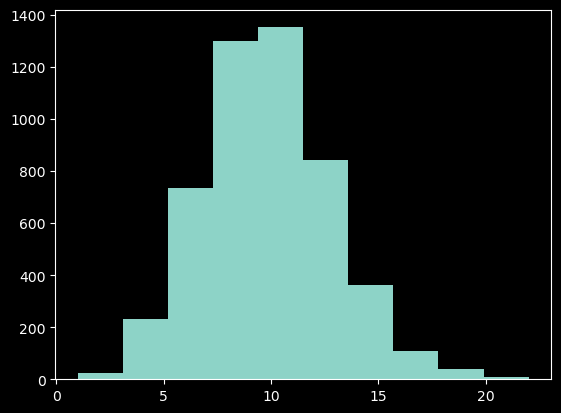

In [116]:
population = np.arange(1000)

all_overlaps = []
for i in range(5003):
    sample1 = np.random.choice(population, 100, replace=False)
    sample2 = np.random.choice(population, 100, replace=False)

    # number of overlaps
    all_overlaps.append(len(set(sample1).intersection(sample2)))

plt.hist(all_overlaps)

# Math is hard

+ Computing symbolic gradients is exact but laborious
+ Numerical gradients are approximate, easy, but expensive
+ If the input to our network is $N$-dimensional, then we need to compute $N$ gradients. For a 1 Megapixel image, this is a million gradient operations per gradient descent step

*Automatic differentiation* is a technique that can compute the *exact* gradient of a function in a computationally-efficient manner.

*Backpropagation* is reverse-mode autodiff applied to deep neural networks.

In [7]:
def double_well(x):
    """Double well potential function"""
    return x**4 - 2*x**2

def double_well_grad(x):
    """Derivative of double well potential function"""
    return 4*x**3 - 4*x

print(double_well(0.12132987))
print(double_well_grad(0.12132987))

-0.029225168711847025
-0.4781751223381389


### Let's write out these functions in terms of basic computational steps

In [8]:
def double_well_primitive(x):
    """Decompose the double well calculation into primitive operations"""
    h1a = x**4
    h1b = 2*x**2
    h2 = h1a - h1b
    return h2

def double_well_primitive_grad(x):
    """Decompose the double well gradient calculation into primitive operations"""
    dh2dh1a = 1
    dh2dh1b = -1
    dh1adx = 4*x**3
    dh1bdx = 4*x
    dh2dx = dh2dh1a * dh1adx + dh2dh1b * dh1bdx
    return dh2dx

print(double_well_primitive(0.12132987))
print(double_well_primitive_grad(0.12132987))

-0.029225168711847025
-0.4781751223381389


## A neural network example

### Forward pass

$$
\hat{\mathbf{y}} = \sigma(\boldsymbol{\theta}_2 \sigma(\boldsymbol{\theta}_1 \mathbf{x}))
$$
for concreteness, we will use the sigmoid nonlinearity $\sigma(x) = \frac{1}{1 + e^{-x}}$.

We start by breaking this into single steps

$$
\mathbf{h}_1^{u} = \boldsymbol{\theta}_1 \mathbf{x}
$$

$$
\mathbf{h}_1 = \sigma(\mathbf{h}_1^{u})
$$

$$
\mathbf{h}_2^{u} = \boldsymbol{\theta}_2 \mathbf{h}_1
$$

$$
\hat{\mathbf{y}} = \sigma(\mathbf{h}_2^{u})
$$


### Backward pass

Suppose we pass an input $\mathbf{x}$ and get an output $\hat{\mathbf{y}}$, and we know the true output is $\mathbf{y}$.

If we are using the mean-squared error loss function, then

$$
\mathcal{L} = \frac{1}{2} \sum_{i=1}^n (\hat{y}_i - y_i)^2 = \frac{1}{2} (\hat{\mathbf{y}} - \mathbf{y})^\top(\hat{\mathbf{y}} - \mathbf{y})
$$

We want to update all the parameters $\boldsymbol{\theta}_1$ and $\boldsymbol{\theta}_2$ to minimize this loss.

We traverse the network *backwards* in order to compute gradients.

$$
\frac{\partial \mathcal{L}}{\partial \boldsymbol{\theta}_2} = \frac{\partial \mathcal{L}}{\partial \hat{\mathbf{y}}} \frac{\partial \hat{\mathbf{y}}}{\partial \mathbf{h}_2^{u}} \frac{\partial \mathbf{h}_2^{u}}{\partial \boldsymbol{\theta}_2}
$$

Solving this sequence from left-to-right,

$$
\frac{\partial \mathcal{L}}{\partial \hat{\mathbf{y}}} = \hat{\mathbf{y}} - \mathbf{y}
$$

$$
\frac{\partial \hat{\mathbf{y}}}{\partial \mathbf{h}_2^{u}} = \hat{\mathbf{y}} (1 - \hat{\mathbf{y}})
$$

$$
\frac{\partial \mathbf{h}_2^{u}}{\partial \boldsymbol{\theta}_2} = \mathbf{h}_1^\top
$$

Putting this all together,

$$
\frac{\partial \mathcal{L}}{\partial \boldsymbol{\theta}_2} = (\hat{\mathbf{y}} - \mathbf{y}) \odot \hat{\mathbf{y}} (1 - \hat{\mathbf{y}}) \mathbf{h}_1^\top
$$



Several things to notice: several of the "intermediate" values we computed during the forward pass reappear here. If we cached these values, then we don't have to recompute them during the backward pass. Also, notice that the sigmoid function's derivative is a function of its output. This is a common pattern in autodiff. In order to keep track of indicies and transposes, it helps to think about the dimensions of the input/output of each primitive operation. Additionally, it's useful to remember the some [rules for matrix multiplication:](https://www.math.uwaterloo.ca/~hwolkowi/matrixcookbook.pdf)

$$
\frac{\partial\mathbf{A} \mathbf{B}}{\partial \mathbf{A}} = \mathbf{B}^\top, \qquad
\frac{\partial\mathbf{A} \mathbf{B}}{\partial \mathbf{B}} = \mathbf{A}
$$
<!-- 
These left-right rules are also used in the derivation of the linear regression pseudoinverse global solution.

Additionally, we should remember the chain rule for derivatives:
$$
\frac{\partial\mathbf{A}(u) \mathbf{B}(u)}{\partial u} = \frac{\partial\mathbf{A}(u)}{\partial u} \mathbf{B}(u) + \mathbf{A}(u) \frac{\partial\mathbf{B}(u)}{\partial u}
$$ -->


In [ ]:
a = np.random.random((2, 2))
x = np.random.random((2, 1))

def ff(x):
    """Feedforward pass"""
    return np.dot(a, x)

def ff_grad(x):
    """Gradient of feedforward pass"""
    return a

### Harder cases: branching paths, loops, and shared weights

### Let the computer do the work

+ Most existing deep learning frameworks are built on top of autodiff
+ Tensorflow, PyTorch, JAX, and many others allow you to specify the neural network as a function, and can compute the gradient automatically as long as everything is differentiable
+ Implictly, these networks build a computation "graph" that is later traversed backwards to compute the gradient
+ Caching forward pass values can speed up the backwards pass, since many derivatives depend on forward pass values

In [17]:
import jax

def double_well(x):
    """Double well potential function"""
    return x**4 - 2*x**2

print("Forward pass value:", double_well_jax(0.12132987))
print("Analytic calculation backwards pass", double_well_grad(0.12132987))
print("Jax autodiff backwards pass", jax.grad(double_well)(0.12132987))


Forward pass value: -0.029225168711847025
Analytic calculation backwards pass -0.4781751223381389
Jax autodiff backwards pass -0.4781751


In [ ]:
## A multilayer perceptron classifier class

class MLPClassifier:

    def __init__(self, n_hidden, n_output, n_features, learning_rate=0.01, max_iter=1000, verbose=False):
        """Initialize the MLP classifier.

        Parameters
        ----------
        n_hidden : int
            Number of hidden units
        n_output : int
            Number of output units
        n_features : int
            Number of features
        learning_rate : float, optional
            Learning rate, by default 0.01
        max_iter : int, optional
            Maximum number of iterations, by default 1000
        verbose : bool, optional
            Print progress, by default False
        """
        self.n_hidden = n_hidden
        self.n_output = n_output
        self.n_features = n_features
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.verbose = verbose

        # Initialize weights
        self.weights = self._initialize_weights()

    def _initialize_weights(self):
        """Initialize weights for the network.

        Returns
        -------
        dict
            Dictionary of weights
        """
        weights = {
            "W1": np.random.normal(0, 0.1, (self.n_features, self.n_hidden)),
            "b1": np.zeros((1, self.n_hidden)),
            "W2": np.random.normal(0, 0.1, (self.n_hidden, self.n_output)),
            "b2": np.zeros((1, self.n_output))
        }
        return weights

    def _sigmoid(self, x):
        """Sigmoid activation function"""
        return 1 / (1 + np.exp(-x))

    def _sigmoid_derivative(self, x):
        """Derivative of sigmoid activation function"""
        return self._sigmoid(x) * (1 - self._sigmoid(x))

    def _forward_pass(self, X):
        """Forward pass through the network.

        Parameters
        ----------
        X : np.ndarray
            Input data

        Returns
        -------
        dict
            Dictionary of activations
        """
        # Input layer
        A1 = X
        # Hidden layer
        Z2 = A1 @ self.weights["W1"] + self.weights["b1"]
        A2 = self._sigmoid(Z2)
        # Output layer
        Z3 = A2 @ self.weights["W2"] + self.weights["b2"]
        A3 = self._